eSpatial - Tutorial

Run eSpatial on example data

This notebook illustrates how to run eSpatial to decipher the spatially resolved enhancer regulation on gene expression through integrating spatial profiling of gene expression and chromatin accessibility.

# Library packages and source functions

In [1]:
# omics
library(Signac)
library(Seurat)
library(SeuratDisk)
library(SummarizedExperiment)
library(GenomeInfoDb)

# plots
library(ggplot2)
library(RColorBrewer)
library(ComplexHeatmap)

# other
library(dplyr)
library(purrr)
library(Matrix)
library(data.table)
library(future)
library(pbapply)

# eSpatial functions
source('./R/functions.R')

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.2.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, ro

# Load the data

The data downloaded from the Broad Institute Single Cell Portal under the following accession numbers SCP2176. The object created using the Seurat standard pipeline including atac assays, rna assays, cell coordinate information, cell type annotation

In [2]:
cre.mat <- readRDS("../Data/cre.mat.rds")
exp.mat <- readRDS("../Data/exp.mat.rds")
meta.data <- readRDS("../Data/meta.data.rds")
cells.coordinates <- readRDS("../Data/cells.coordinates.rds")
load("../Data/hg38_refSeq.RData")
chrom.assays <- CreateChromatinAssay(counts = cre.mat,
                              assays = "peaks")
obj <- CreateSeuratObject(chrom.assays,
                         assay = "peaks",
                         meta.data =meta.data)
obj[["RNA"]] <- CreateAssayObject(counts = exp.mat)
obj@reductions[["cod"]] <- cells.coordinates
obj

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_”


An object of class Seurat 
90002 features across 1992 samples within 2 assays 
Active assay: peaks (53401 features, 0 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: cod

# Calculate specificty scores

For each gene/cis-regulatory element in a specific spatial domain, eSpatial calculated its fold change of the average log-normalized counts in a specific spatial domain versus the rest spatial domains.

In [3]:
clusters <- as.character(unique(obj$finalType))
Idents(obj) <- obj$finalType
exp.avg <- SpecificityScore(object = obj,
                            assays = "RNA",
                            clusters = clusters)

peaks.avg <- SpecificityScore(object = obj,
                              assays = "peaks",
                              clusters = clusters)
head(exp.avg)
head(peaks.avg)                            

Warning message in `[<-.data.frame`(`*tmp*`, , clusters, value = structure(list(:
“replacement element 1 has 53401 rows to replace 36601 rows”
Warning message in `[<-.data.frame`(`*tmp*`, , clusters, value = structure(list(:
“replacement element 2 has 53401 rows to replace 36601 rows”
Warning message in `[<-.data.frame`(`*tmp*`, , clusters, value = structure(list(:
“replacement element 3 has 53401 rows to replace 36601 rows”
Warning message in `[<-.data.frame`(`*tmp*`, , clusters, value = structure(list(:
“replacement element 4 has 53401 rows to replace 36601 rows”
Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”


,Tcell_2,Tcell_1,tumour_2,tumour_1
,<dbl>,<dbl>,<dbl>,<dbl>
MIR1302-2HG,-1.0291697,-1.948177,0.8874455,1.4041643
FAM138A,-3.9293058,-3.914996,-3.6585436,5.1957659
OR4F5,-0.7324579,-7.148172,1.4272465,1.3385233
AL627309.1,-1.5945879,-1.354781,0.7376574,1.5459349
AL627309.3,-4.8811630,-4.866365,7.2100267,-4.8556151
AL627309.2,-6.0236310,-6.008547,4.3546559,-0.4456889


,Tcell_2,Tcell_1,tumour_2,tumour_1
,<dbl>,<dbl>,<dbl>,<dbl>
chr1-9775-10674,-1.0291697,-1.948177,0.8874455,1.4041643
chr1-15652-16482,-3.9293058,-3.914996,-3.6585436,5.1957659
chr1-17031-17917,-0.7324579,-7.148172,1.4272465,1.3385233
chr1-180621-181371,-1.5945879,-1.354781,0.7376574,1.5459349
chr1-183913-184830,-4.8811630,-4.866365,7.2100267,-4.8556151
chr1-186586-187505,-6.0236310,-6.008547,4.3546559,-0.4456889


# Define enhancer clusters of genes

eSpatial defines enhancer clusters of genes based on the correlation between enhancer chromatin accessibility and gene expression across spots/spatial neighbor networks.

THIS PROCESS NEED AROUND 1 HOUR!!!

In [4]:
exp.mat <- obj@assays$RNA@data
cre.mat <- obj@assays$peaks@data
GPTab <- GPCor(cre.mat = cre.mat,
              exp.mat = exp.mat,
              genome = "hg38")

Assuming paired scATAC/scRNA-seq data ..

Peaks with 0 accessibility across cells exist ..

Removing these peaks prior to running correlations ..

Important: peak indices in returned gene-peak maps are relative to original input SE

Genes with 0 expression across cells exist ..

Removing these genes prior to running correlations ..



Number of peaks in ATAC data: 52996 
Number of genes in RNA data: 27588 

Taking peak summits from peak windows ..
Finding overlapping promoter-gene pairs ..
Found  114356 total promoter-peak pairs for given TSS window ..
Number of peak summits that overlap any gene promoter window:  21592 
Number of gene promoter windows that overlap any peak summit:  101266 


Num genes overlapping TSS annotation and RNA matrix being considered:  27245 
Finding overlapping peak-gene pairs ..
Found  82703 total gene-peak pairs for given TSS window ..
Number of peak summits that overlap any gene TSS window:  25632 
Number of gene TSS windows that overlap any peak summit:  22676 



Loading required package: foreach

Warning message:
“package ‘foreach’ was built under R version 4.2.3”

Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.2.3”
Loading required package: parallel



In [5]:
GPTabFilt <- subset(GPTab, !is.na(estimate) & estimate > 0 & class == "corr")
# Remove multi-mapping peaks (force 1-1 mapping)
cat("Keeping max correlation for multi-mapping peaks ..\n")
GPTabFilt <- GPTabFilt %>% group_by(Peak) %>% filter(estimate==max(estimate))


Keeping max correlation for multi-mapping peaks ..


# Depict spatial patterns of enhancers for genes expressed in multiple spatial domains

eSpatial first identified gene expression modules using k-means clustering. This clustering grouped genes showing similar expression patterns across spatial domains.

In [6]:
exp.mat <- as.matrix(exp.avg)
genes <- intersect(rownames(exp.mat), GPTabFilt$Gene)
exp.mat <- exp.mat[genes,]
clusters <- c("tumour_1","tumour_2" ,
             "Tcell_1","Tcell_2")
gene.module <- geneModules(exp.mat = exp.mat,
                         k = 6,
                         clusters = clusters)

Visualize the gene modules as heatmap

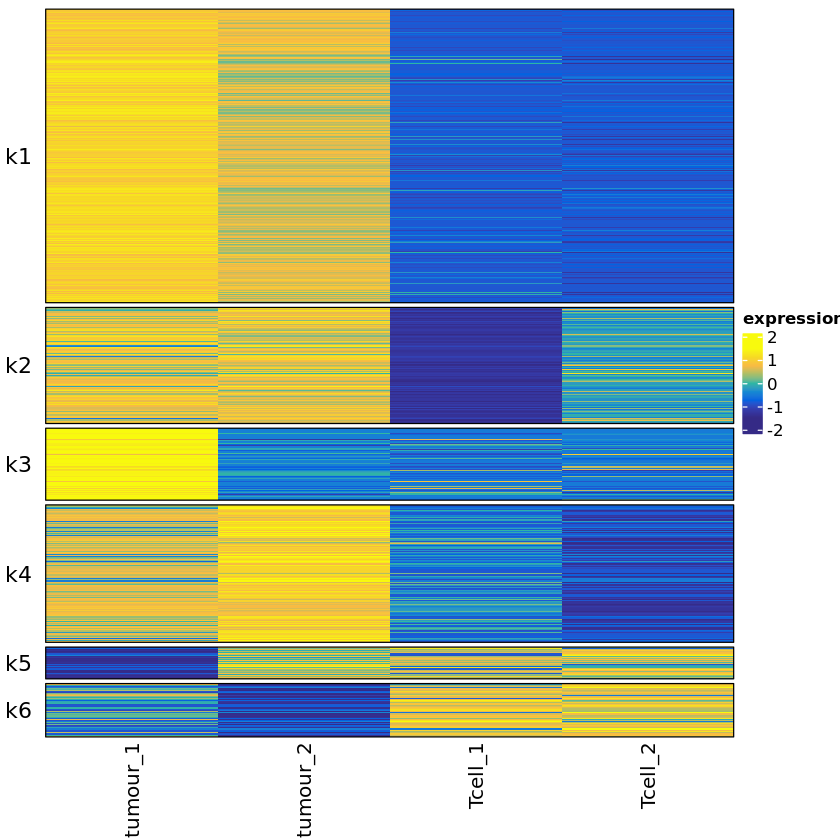

In [7]:
matrix <- exp.mat[gene.module$genes, clusters]
plotHeatmap(matrix = matrix,
            row_split = gene.module$kmeans)

For each gene module, eSpatial ordered their enhancers based on the specificity scores and visualize.

Tcell_2    Tcell_1   tumour_2   tumour_1 
-4.2487385 -4.4915836  0.2594166  1.6334912

Tcell_2     Tcell_1    tumour_2    tumour_1 
-0.77067738 -0.79408090  0.09295612  0.53044894

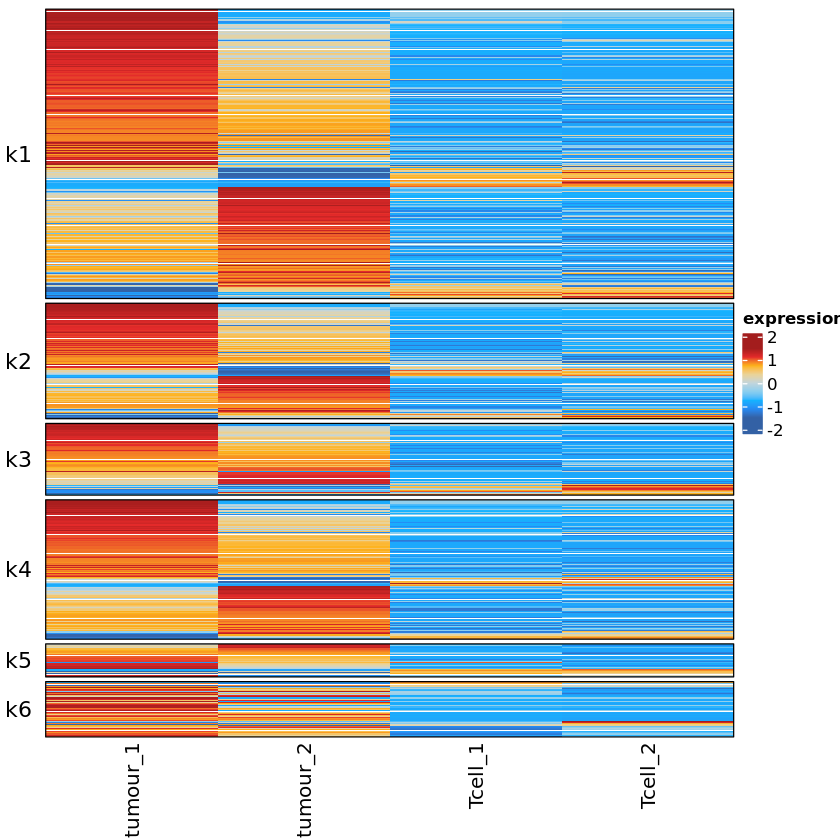

In [8]:
cre.mat <- as.matrix(peaks.avg)
colMeans(cre.mat)
cre.mat <- scale(cre.mat,center = F)
colMeans(cre.mat)
enh.order <- enhancerOrder(exp.mat = exp.mat,
                          cre.mat = cre.mat,
                          genemodule = gene.module,
                          gppairs = GPTabFilt,
                          clusters = clusters,
                          cutoff = 0.02)
matrix <- cre.mat[enh.order$peak, clusters]
plotHeatmap(matrix = matrix,
            row_split = enh.order$genemodule,
            col = c("#3361A5","#248AF3","#14B3FF","#88CEEF","#C1D5DC","#EAD397","#FDB31A","#E42A2A","#A31D1D"))            

For each gene module, eSpatial defined the spatial patterns of those enhancers regulating the genes within that module.

In [9]:
enh.pattern <- enhancerPattern(exp.mat = exp.mat,
                              cre.mat = cre.mat,
                              genemodule = gene.module,
                              gppairs = GPTabFilt,
                              clusters = clusters,
                              cutoff.cluster = 0.02,
                              cutoff.bin = 0)



# Decode the spatially divergent combinations of enhancers

eSpatial quantified the diversity of spatial patterns of enhancers within a specific enhancer cluster

THIS PROCESS NEED AROUND 15 MINUTES!

In [10]:
enh.combination <- enhancerCombination(enh.pattern = enh.pattern,
                                      gppairs = GPTabFilt)
head(enh.combination)

,Gene,enh.Num,exp.Domain,enh.Pattern.Num
,<chr>,<int>,<int>,<int>
1,ZNF595,1,2,1
2,SNRNP25,1,2,1
3,ZNF718,2,2,1
4,ZMYND11,2,2,1
5,AC093627.4,1,2,1
6,USP14,1,2,1
